In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import datetime as dt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [4]:
#importing Cocoa Beans dataset showing daily averages across several markets
df = pd.read_csv(r'C:\Users\13473\Documents\cocoa_project\Dailycocoaprices3.csv', header=0)
df['Date'] = pd.to_datetime(df.iloc[:, 0])
df.head()

,Date,London futures (sterling/tonne),NY futures (dollars/tonne),ICCO daily (dollars/tonne),ICCO daily (euro/tonne)
0,2025-03-11,6389.33,8249.00,8255.20,7555.16
1,2025-03-10,6510.00,8340.00,8364.07,7723.80
2,2025-03-07,6506.33,8197.67,8297.70,7643.01
3,2025-03-06,6421.00,8178.67,8227.19,7605.62
4,2025-03-05,6337.33,8172.33,8160.91,7576.18


In [5]:
pounds=df['London futures (sterling/tonne)']
dollars=df['NY futures (dollars/tonne)']
icco_dollars=df['ICCO daily (dollars/tonne)']
icco_euros=df['ICCO daily (euro/tonne)']

In [6]:
icco_dollars.describe()

count     7820.000000
mean      2358.856853
std       1356.112690
min        774.100000
25%       1558.055000
50%       2202.565000
75%       2743.002500
max      11984.660000
Name: ICCO daily (dollars/tonne), dtype: float64

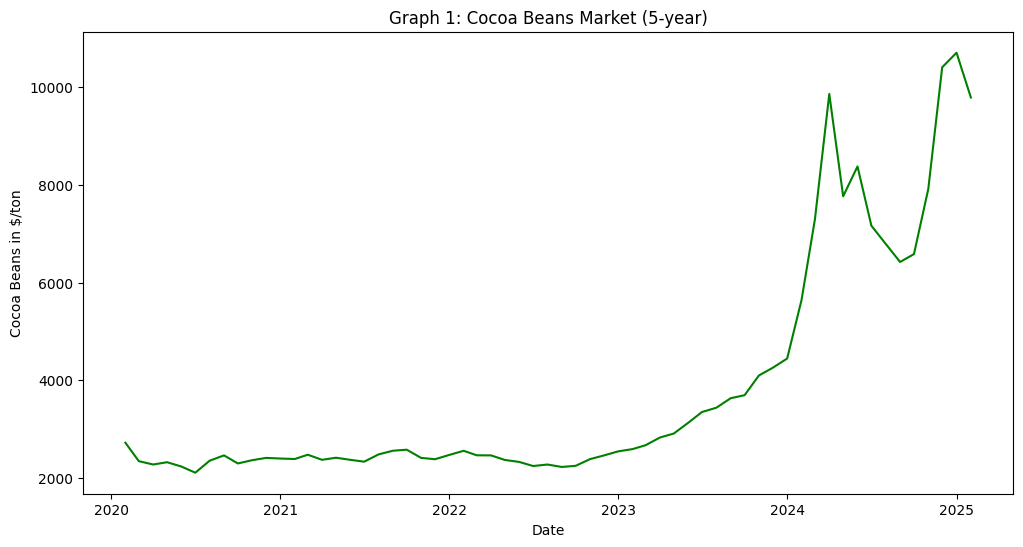

In [23]:
#FRED graph showing the 5-year market prices of cocoa beans. 
cocoafred=pd.read_csv(r'C:\Users\13473\Downloads\PCOCOUSDM.csv', header=0)
cocoafred['observation_date'] = pd.to_datetime(cocoafred['observation_date'])
plt.figure(figsize=(12,6))
plt.plot(cocoafred['observation_date'],cocoafred['PCOCOUSDM'], label='Global Cocoa Prices $/metric ton', color='green')

#labels
plt.title('Graph 1: Cocoa Beans Market (5-year)')
plt.xlabel('Date')
plt.ylabel('Cocoa Beans in $/ton')
#plt.xlim(pd.to_datetime('2020-02-01'), pd.to_datetime('2025-02-01'))
plt.show()

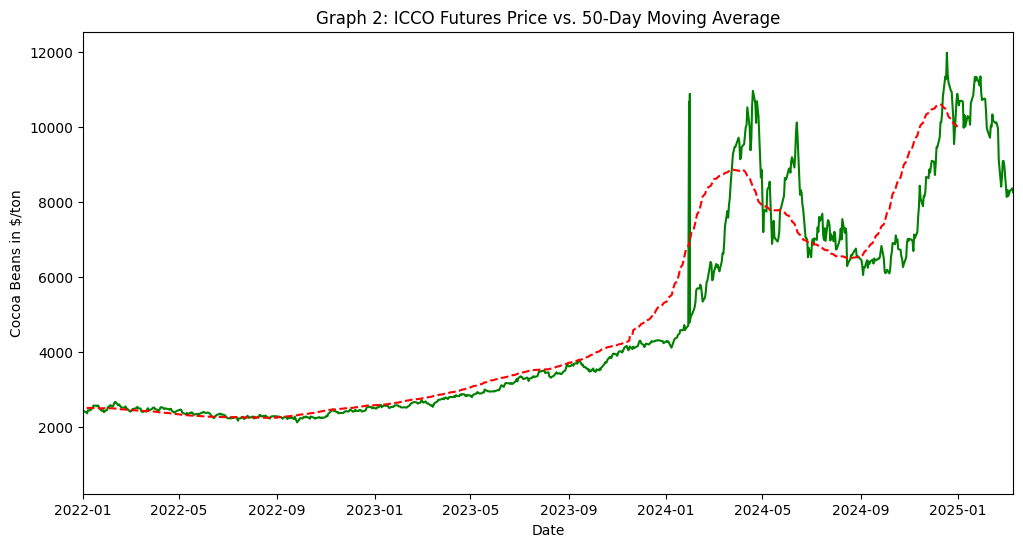

In [24]:
#plotting ICCO futures price and 50 day moving average for the last 3 years
plt.figure(figsize=(12,6))
df['50dayMA']=icco_dollars.rolling(window=50).mean()
plt.plot(df['Date'],df['ICCO daily (dollars/tonne)'], label='ICCO Cocoa Beans ($/ton)', color='green')
plt.plot(df['Date'],df['50dayMA'], label='50-Day Moving Average', color='red', linestyle='--')
#df.sort_values('Date', inplace=False)

#label and trimming
plt.title('Graph 2: ICCO Futures Price vs. 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Cocoa Beans in $/ton')
plt.xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2025-03-11'))
plt.show()

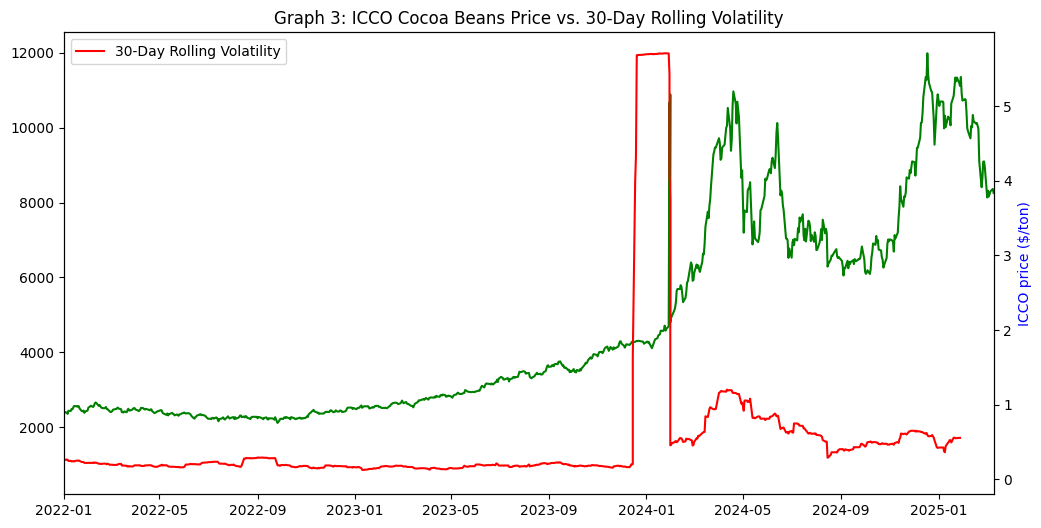

In [25]:
#plotting futures price and 30-day rolling volatility
plt.figure(figsize=(12, 6))
df['Daily Returns'] = df['ICCO daily (dollars/tonne)'].pct_change()
df['Rolling Volatility'] = df['Daily Returns'].rolling(window=30).std() * (252 ** 0.5) #square root of total days in a year that market is open
plt.plot(df['Date'], df['ICCO daily (dollars/tonne)'], label='ICCO price ($/ton)', color='green')

#setting up the second y-axis
ax2 = plt.gca().twinx()
ax2.plot(df['Date'], df['Rolling Volatility'], label='30-Day Rolling Volatility', color='red', linestyle='-')
ax2.legend(loc='upper left')
ax2.set_ylabel('Volatility (Annualized)', color='red')

#setting up the graph and labels
plt.title('Graph 3: ICCO Cocoa Beans Price vs. 30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('ICCO price ($/ton)', color='blue')
plt.xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2025-03-11'))
plt.show()

In [10]:
dftwo = pd.read_csv(r'C:\Users\13473\Downloads\cocoabeanexports1.csv', header=0)

#filterting to show only weight quantities of exports
tons_df = dftwo[dftwo['Unit'] == 't']

#remove scientific notation
print(tons_df['Value'].describe().apply(lambda x: format(x, '.2f')))

count        34.00
mean     205597.84
std      144610.58
min       14451.07
25%       45550.17
50%      200205.50
75%      325882.04
max      490778.00
Name: Value, dtype: object


In [11]:
#setting up subset dataframes from master dataframe
dfmaster=pd.read_csv(r'C:\Users\13473\Downloads\cocoamasterfile.csv', header=0)
dfmaster['Year'] = pd.to_datetime(dfmaster['Year'], format='%Y')

#df for only cocoa bean exports out of Ghana
df_ghanabeans=dfmaster[(dfmaster['Area'] == 'Ghana') &
                       (dfmaster['Item']=='Cocoa beans') &
                       (dfmaster['Unit']=='t')]
#df for only cocoa bean exports out of Indonesia
df_indobeans=dfmaster[(dfmaster['Area'] == 'Indonesia') &
                      (dfmaster['Item']=='Cocoa beans') &
                      (dfmaster['Unit']=='t')]

#Filtering the master df by Country and unit of measurement, for all cocoa products.
#'all cocoa products' include: Cocoa beans, husks, powder, paste, and butter.
df_ghanacocoa=dfmaster[(dfmaster['Area'] == 'Ghana') &
                       (dfmaster['Unit']=='t')]
#sum of all cocoa product exports from Ghana, grouped by year
gh_allcocoa = df_ghanacocoa.groupby(df_ghanacocoa['Year']).agg({'Value': 'sum'}).reset_index()


df_indococoa=dfmaster[(dfmaster['Area'] == 'Indonesia') &
                       (dfmaster['Unit']=='t')]
#sum of all cocoa product exports from Indonesia, grouped by year.
indo_allcocoa = df_indococoa.groupby(df_indococoa['Year']).agg({'Value': 'sum'}).reset_index()
gh_allcocoa.head()

,Year,Value
0,1990-01-01,269726.0
1,1991-01-01,265203.0
2,1992-01-01,243098.0
3,1993-01-01,278380.0
4,1994-01-01,252419.0


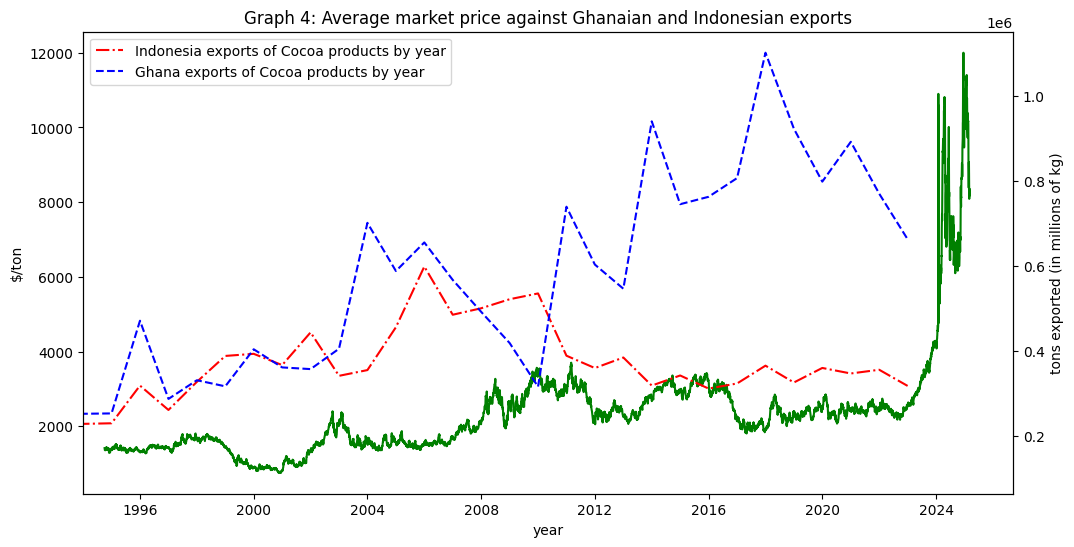

In [26]:
#setting up and plotting for the first y-axis that shows the market price of cocoa beans (in $/ton), data from 1994 to 2025
#market price is the average of NY Futures and International Cocoa Organization's dollar price 
df['average']=df[['NY futures (dollars/tonne)','ICCO daily (dollars/tonne)']].mean(axis=1)
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['average'], label='Average of ICCO price and NY Futures', color= 'green')
tons_df['Year'] = pd.to_datetime(tons_df['Year'], format='%Y')

#axes
plt.xlabel('year')
plt.ylabel('$/ton')
plt.xlim(pd.to_datetime('1994-01-01'), None)

#2nd y-axis that shows the export quanities (in millions of kg) of cocoa products. Data from 1990 to 2023
ax2 = plt.gca().twinx()
ax2.plot(indo_allcocoa['Year'], indo_allcocoa['Value'], label='Indonesia exports of Cocoa products by year', color='red', linestyle='-.')
ax2.set_ylabel('tons exported (in millions of kg)')
ax2.plot(gh_allcocoa['Year'], gh_allcocoa['Value'], label='Ghana exports of Cocoa products by year', color='blue', linestyle='--')

#title and legend
plt.title('Graph 4: Average market price against Ghanaian and Indonesian exports')
plt.legend()
plt.show()

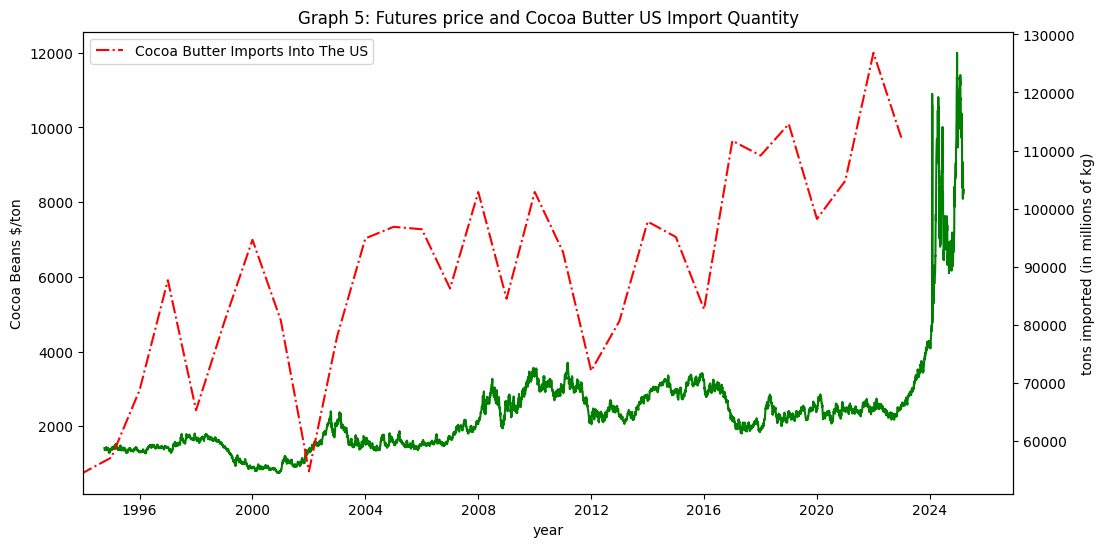

In [27]:
#loading dataset of cocoa butter imports into the U.S
dfimports=pd.read_csv(r'C:\Users\13473\Downloads\cocoaimports1.csv')
dfimports['Year'] = pd.to_datetime(dfimports['Year'], format='%Y')
dfbutter=dfimports[(dfimports['Unit']=='t')]

#market price of cocoa beans dataset used in the previous graph
df['average']=df[['NY futures (dollars/tonne)','ICCO daily (dollars/tonne)']].mean(axis=1)
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['average'], label='Average of ICCO price and NY Futures', color= 'green')
tons_df['Year'] = pd.to_datetime(tons_df['Year'], format='%Y')

plt.xlabel('year')
plt.ylabel('Cocoa Beans $/ton')

#plotting import data
ax2 = plt.gca().twinx()
ax2.plot(dfbutter['Year'], dfbutter['Value'], label='Cocoa Butter Imports Into The US', color= 'red', linestyle='-.')
ax2.set_ylabel('tons imported (in millions of kg)')

#label and trimming
plt.xlim(pd.to_datetime('1994-01-01'), None)
plt.legend()
plt.title('Graph 5: Futures price and Cocoa Butter US Import Quantity')
plt.show()